# Ising model simulation with Monte Carlo method

In [53]:
import os
import shutil
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [3]:
fdir = './out/ising/'
ffmt = 'pdf'
fdpi = 150

axistitlesize = 26
axisticksize = 23
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15
sc = 10

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': False,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

## Characteristic parameters of the system

In [14]:
k_B = 1.380648e-23    # Boltzmann constant
h = 0                 # External magnetic field
J = 1                 # Arbitrary J
T = 200               # Temperature
beta = 1 / (k_B * T)  # Characteristic value

## Random +1 or -1

In [6]:
def get_random_spins(size):
  return np.sign(np.random.random(size) - 0.5)

# Ising model simulation on 2D lattice

In [7]:
# Number of spins in a row at the 2D case
N_spin = 30

start_offset = 2000

In [8]:
# The current positions of the spins
spins = get_random_spins(size=(N_spin, N_spin))

In [9]:
def e_i(spins, s_i,
        J=1, h=0):

  e = 0
  for s_j in spins.flat:
    e += -J/2 * s_i * s_j
  
  return e - h*s_i

In [10]:
def E(spins,
      J=1, h=0, L_cut=2):

  E = 0
  for s_i in spins.flat:
    E += e_i(spins, s_i, J, h)

  return E

In [11]:
def delta_E(spins, i, j,
            J=1, h=0):
  
  dE = 0
  indeces = [[0,1],[0,-1],[1,0],[-1,0]]
  
  for rel in indeces:
    dE += 2 * spins[i,j] * spins[(i + rel[0])%spins.shape[0],
                                 (j + rel[1])%spins.shape[1]]
  
  return dE * J - h*spins[i,j]

In [29]:
def simulation_step(spins,
                    beta=10, J=1, h=0):

  # Choose random index
  r_i = np.random.randint(0, spins.shape[0])
  r_j = np.random.randint(0, spins.shape[1])
  
  # Calculate energy difference
  dE = delta_E(spins, r_i, r_j)
  
  # If dE <= 0, then execute the flip
  if(dE < 0):
    spins[r_i, r_j] *= -1
  elif(dE == 0):
    if(np.random.random() < 0.5):
      spins[r_i, r_j] *= -1
  # If dE > 0, choose a random number X, between 0 and 1
  # If X < e^(-beta * dE), then execute the spin flip
  # If not, then leave the spins' state untouched and continue with the next step
  else:
    if(np.random.random() < np.exp(-beta * dE)):
      spins[r_i, r_j] *= -1

  return spins

In [33]:
def run_simulation(spins, N_steps,
                   T, J, h):

  beta = 1 / (k_B * T)
  spins_n = spins.copy()
  for _ in range(N_steps):
    spins_n = simulation_step(spins_n,
                              beta=beta, J=J, h=h)
  
  np.save(file=os.path.join(fdir, f'spins_T{T}'),
          arr=spins_n)
  
  return spins_n

In [54]:
Ts = np.array([1,10,100,300])
spins = get_random_spins(size=(400,400))
N_steps=100_000_000

if not os.path.exists(fdir):
  os.makedirs(fdir)

_ = Parallel(n_jobs=4)(delayed(run_simulation)(spins,
                                               N_steps=N_steps,
                                               T=T, J=J, h=h) for T in Ts)

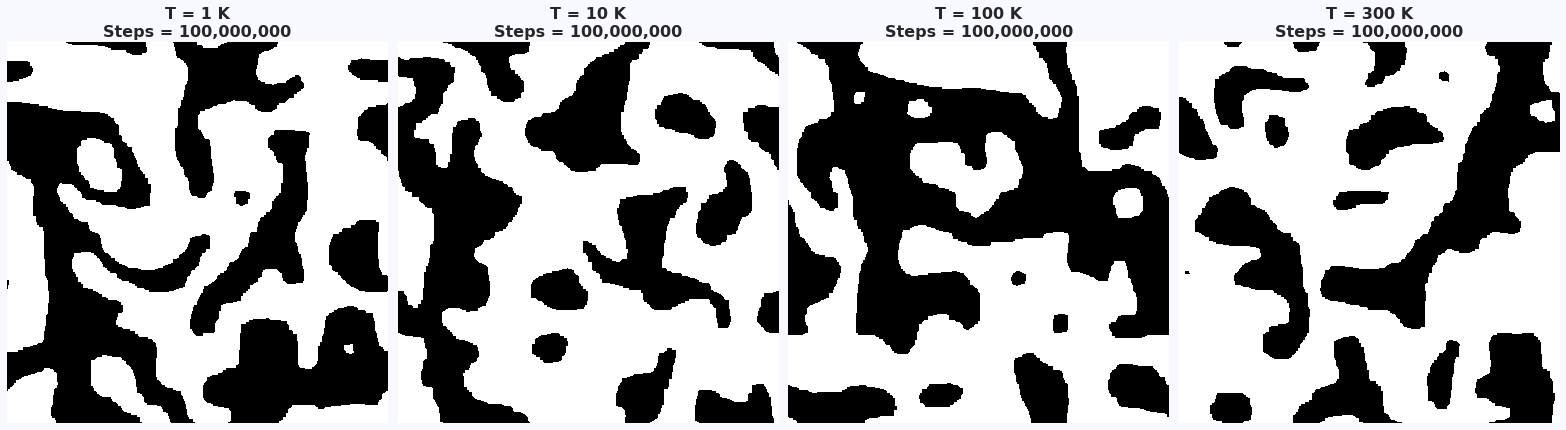

In [63]:
nrows, ncols = 1, Ts.size
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*7, nrows*7),
                         facecolor='ghostwhite')
fig.subplots_adjust(wspace=0.0)

spin_files = {
  f.split('T')[1].split('.')[0] : f for f in os.listdir(fdir) if '.npy' in f
}
for T, ax in zip(Ts, axes.flat):
  spins_n = np.load(file=os.path.join(fdir, spin_files[f'{T}']))
  ax.axis('off')
  ax.imshow(spins_n, cmap='Greys',
            interpolation='none')
  ax.set_title(f'T = {T} K\nSteps = {N_steps:,}',
               fontsize=16, fontweight='bold')
  
plt.show()